## SVD

> Source: <br/>
> https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0 <br/>
> Statistical Learning with Sparsity, Trevor Hastie et al.

- Principal component vectors are in order of directions which yield highest sample variance. Principal component vectors are orthogonal.
- Methods either find directions of maximum variance or minimising reconstruction error associated with particular generative model.

In [9]:
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.ensemble import RandomForestClassifier

In [10]:
# 1797 8x8 pixel images, images presented as flattened 64-length vectors.
X, y = load_digits(return_X_y=True)
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (1797, 64)
y: (1797,)


In [11]:
# Split into test and train set
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.25, random_state=42)

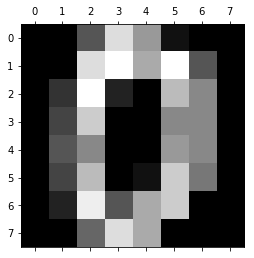

In [12]:
# Example of image
image = X[0]
image = image.reshape((8, 8))
plt.matshow(image, cmap = 'gray')

> numpy.linalg.svd is a wrapper around xGESDD in LAPACK. Singular value decompositions proceed in two stages. First, the matrix to be decomposed is reduced to bidiagonal form. The algorithm used to reduce to bidiagonal form in LAPACK is probably the Lawson-Hanson-Chan algorithm, and it does use QR factorization at one point. Lecture 31 in Numerical Linear Algebra by Trefethen and Bau gives an overview of this process. Then, xGESDD uses a divide-and-conquer algorithm to calculate the singular values and left and right singular vectors from the bidiagonal matrix. To get background on this step, you'll need to consult Matrix Computations by Golub and Van Loan, or Applied Numerical Linear Algebra by Jim Demmel.

Low Rank Image Shape: (8, 8)


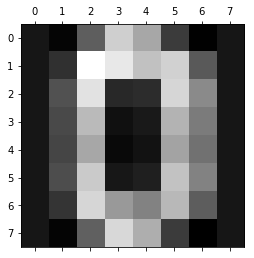

In [13]:
# Performing SVD directly on image
# image: m x n, U: m x m, s: min(n, m) vector, V: n x n
U, s, Vh = np.linalg.svd(image)

# Reduced rank Sigma (S: m x n)
S = np.zeros((image.shape[0], image.shape[1]))
S[:s.shape[0], :s.shape[0]] = np.diag(s)
n_component = 2

# S: m x n_component
S = S[:, :n_component]

# First n_component rows of VT. Rows of VT are principal component directions.
Vh = Vh[:n_component, :]

# Reconstruct low rank approximation of matrix
A = U.dot(S.dot(Vh))
print('Low Rank Image Shape: {}'.format(A.shape))
plt.matshow(A, cmap = 'gray')

Note in the operations above, the entire left principal component vector matrix needs to be retained to reconstruct the low rank image. Its size would be similar to the original image matrix if m is similar to n.

In [14]:
def reduce(x_, arr):
    # Performing SVD directly on image using Numpy SVD function
    x = x_.reshape((8, 8))
    # image: m x n, U: m x m, s: min(n, m) vector, V: n x n
    U, s, Vh = np.linalg.svd(x)

    # Reduced rank Sigma (S: m x n)
    S = np.zeros((image.shape[0], image.shape[1]))
    S[:s.shape[0], :s.shape[0]] = np.diag(s)
    n_component = 2

    # S: m x n_component
    S = S[:, :n_component]

    # First n_component rows of VT. Rows of VT are principal component directions.
    Vh = Vh[:n_component, :]

    # Reconstruct low rank approximation of matrix
    P = U.dot(S)
    
    if len(arr) == 0:
        arr = np.array([P.flatten()])
    else:
        arr = np.vstack((arr, P.flatten()))
    return arr

def reduce2(x_, arr):
    # Using SciKit learns TruncatedSVD function which acts directly on image x instead of covarience matrix of x.
    svd = TruncatedSVD(n_components=2)
    x = x_.reshape((8, 8))
    P = svd.fit_transform(x)
    
    if len(arr) == 0:
        arr = np.array([P.flatten()])
    else:
        arr = np.vstack((arr, P.flatten()))
    return arr

def reduce3(X_, n_component=None, V=None):
    # If loading matrix V supplied, only returns principal components for input set. 
    # If V not supplied, V matrix first calculated by performing SVD on entire input set.
    if V is None:
        # image: m x n, U: m x m, s: min(n, m) vector, V: n x n
        U, s, Vh = np.linalg.svd(X_)

        # First n_component rows of VT. Rows of VT are principal component directions.
        Vh = Vh[:n_component, :]

        # Reduced Data
        return X_.dot(Vh.T), Vh.T
    else:
        return X_.dot(V)
    
    

In [15]:
def reduceSparse(X_, n_component=None, V=None):
    if V is None:
        transformer = SparsePCA(n_components=n_component,
        normalize_components=True,
        random_state=42)
        transformer.fit(X_)
        return transformer.transform(X_), transformer.components_
    else:
        return X_.dot(V)
    

In [16]:
X_sparse_tr, V = reduceSparse(X_tr, n_component=16)
print('Shape of V: {}'.format(V.shape))
out = [print('Number of non-zero loading values for component {}: {}'.format(n + 1, sum(i != 0))) for n,i in enumerate(V)]

Shape of V: (16, 64)
Number of non-zero loading values for component 1: 35
Number of non-zero loading values for component 2: 36
Number of non-zero loading values for component 3: 43
Number of non-zero loading values for component 4: 35
Number of non-zero loading values for component 5: 38
Number of non-zero loading values for component 6: 37
Number of non-zero loading values for component 7: 34
Number of non-zero loading values for component 8: 34
Number of non-zero loading values for component 9: 28
Number of non-zero loading values for component 10: 38
Number of non-zero loading values for component 11: 36
Number of non-zero loading values for component 12: 34
Number of non-zero loading values for component 13: 38
Number of non-zero loading values for component 14: 36
Number of non-zero loading values for component 15: 38
Number of non-zero loading values for component 16: 32


Visual representation of loading vectors:


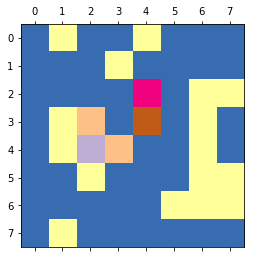

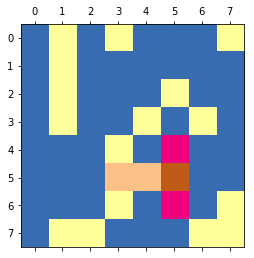

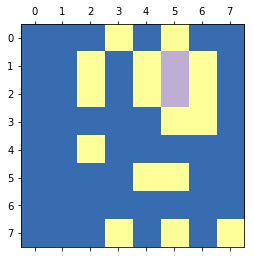

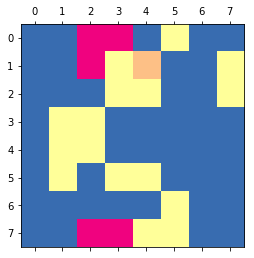

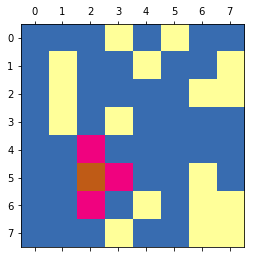

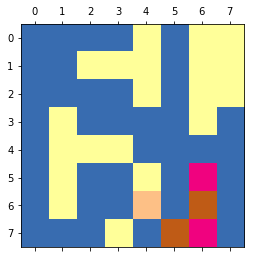

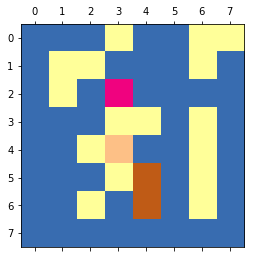

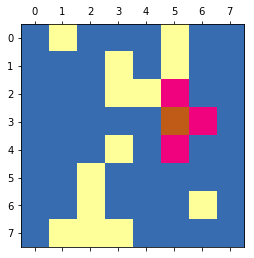

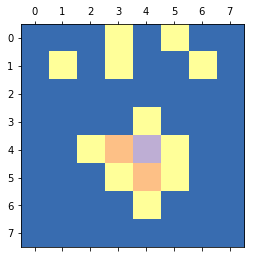

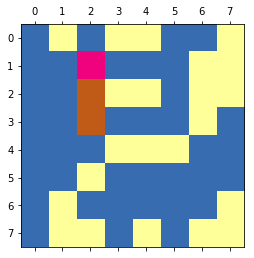

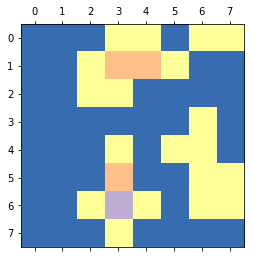

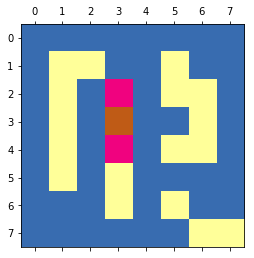

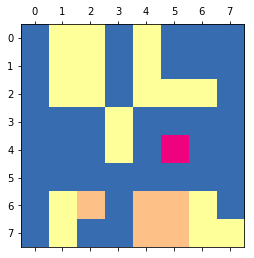

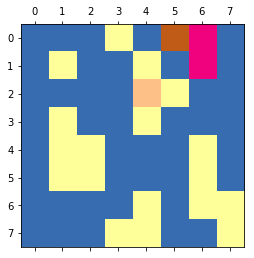

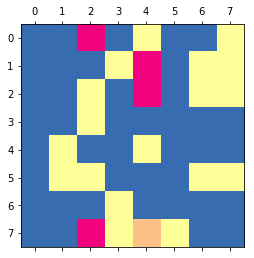

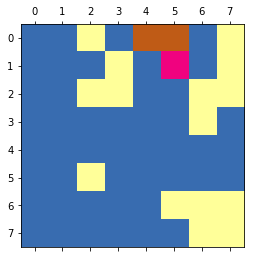

In [17]:
print('Visual representation of loading vectors:')
mynorm = plt.Normalize(vmin=-1, vmax=1)
for vec in V:
    plt.matshow(vec.reshape((8,8)), cmap = 'Accent', norm=mynorm)

In [18]:
norm_X_te = X_te - np.mean(X_tr, axis=0)
X_sparse_te = reduceSparse(norm_X_te, V=V.T)
print('X_sparse_tr Shape: {}'.format(X_sparse_tr.shape))
print('X_sparse_te Shape: {}'.format(X_sparse_te.shape))

X_sparse_tr Shape: (1347, 16)
X_sparse_te Shape: (450, 16)


In [19]:
X_low_tr = np.array([])
X_low_te = np.array([])
for x_ in X_tr:
    X_low_tr = reduce(x_, X_low_tr)
for x_ in X_te:
    X_low_te = reduce(x_, X_low_te)

print('X_low_tr Shape: {}'.format(X_low_tr.shape))
print('X_low_te Shape: {}'.format(X_low_te.shape))

X_low_tr Shape: (1347, 16)
X_low_te Shape: (450, 16)


In [20]:
X_low2_tr = np.array([])
X_low2_te = np.array([])
for x_ in X_tr:
    X_low2_tr = reduce2(x_, X_low2_tr)
for x_ in X_te:
    X_low2_te = reduce2(x_, X_low2_te)

print('X_low2_tr Shape: {}'.format(X_low2_tr.shape))
print('X_low2_te Shape: {}'.format(X_low2_te.shape))

X_low2_tr Shape: (1347, 16)
X_low2_te Shape: (450, 16)


In [21]:
X_reduced_tr, V = reduce3(X_tr, 16)
X_reduced_te = reduce3(X_te, V=V)
print('X_reduced_tr Shape: {}'.format(X_reduced_tr.shape))
print('X_reduced_te Shape: {}'.format(X_reduced_te.shape))

X_reduced_tr Shape: (1347, 16)
X_reduced_te Shape: (450, 16)


In [22]:
def rf_model(model, X_tr_, X_te_, y_tr_, y_te_):
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_tr_, y_tr_)
    predictions = rf.predict(X_te_)
    accuracy = round((sum(predictions == y_te_)/y_te_.shape[0]) * 100, 2)
    print(model + ' Accuracy: {}%'.format(accuracy))

In [23]:
rf_model('Original Data', X_tr, X_te, y_tr, y_te)

Original Data Accuracy: 97.56%


In [24]:
rf_model('Numpy SVD on individual images,', X_low_tr, X_low_te, y_tr, y_te)

Numpy SVD on individual images, Accuracy: 91.11%


In [25]:
rf_model('Truncated SVD on individual images,', X_low2_tr, X_low2_te, y_tr, y_te)

Truncated SVD on individual images, Accuracy: 92.67%


In [26]:
rf_model('SVD on training set with principal directions preserved from training,', X_reduced_tr, X_reduced_te, y_tr, y_te)

SVD on training set with principal directions preserved from training, Accuracy: 97.11%


In [27]:
rf_model('Sparse PCA with loading vectors from training used to reduce test set', X_sparse_tr, X_sparse_te, y_tr, y_te)

Sparse PCA with loading vectors from training used to reduce test set Accuracy: 95.56%


This analysis reveals that SVD can be used as a means to reduce the number of features required to create an effective classifier for handwritten digits. Three different methods of dimensionality reduction were compared in the analysis:

- Using SVD to reduce dimensions of training set and then using principal direction vectors derrived from training set to reduce test set.
- Using SVD to independently reduce dimensions of each image feature vector, by preserving only two features per pixel row in image.
- Using Sparse PCA to reduce dimensions of training set, by identifying sparse loading vectors for each principal component, and then using loading vectors derrived from training set to reduce test set.

All three results yielded high levels of accuracy, with the method where SVD was applied on the whole training set yielding results that were almost identical to the accuracy of the classifier trained on the orginal data. Given $m > n$ for a $m \times n$ matrix, the worst case algorithmic complexity of applying SVD is $O(mn^2)$. In the method above where SVD is applied independently to each image feature vector, this complexity reduces to $O(mn^{1.5})$. For large values of $n$ this can translate into significant time savings when training a model. Furthermore, this method is also advantageous for online learning workflows as new data can be reduced independently before being included in training sets. 

The results of the model trained using data reduced using Sparse PCA analysis are better than the method of applying regular PCA (SVD) to each individual image. The benefit of Sparse PCA is that the loading vectors used to reduce data into 16 components do not require every feature described in the original data set. The selection of non-zero features within a particular vector can increase the interpretability of classification results with reduced data. Looking at the visual representations of the loading vectors above, it can be seen that the choice of non-zero vectors are somewhat related to the structural features of handwritten numbers.  